In [1]:
import numpy as np
import math
import random
import copy
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline  

In [215]:
class Node(object):
    """ 
    Useful for the opinion network or neutral network.
    """
    def __init__(self, value = 0, edges = []):
        self.value = value
        self.edges = edges

class Edge(object):
    def __init__(self, fnode, tnode, value):
        self.fnode = fnode
        self.tnode = tnode
        self.value = value

In [507]:
import numpy as np
import math
import random
import copy

#Create three possibilities to represent graph?
#TODO: create possibility to give nodes names? or just number-name dict?
#edgelist with weighted graph possibility
class Graph(object):
    """
    Input can be as a matrix, list of edges as tuples,
    dictionary of connections between nodes.
    Matrix should be upper triangular for both directed
    and undirected graphs. Edges without duplicates 
    (also for directed graph). Nondict with all connections.
    """
    def __init__(self, matrix = [], nnodes = 1, nodes = [], \
                 edges = [], nodevalues = [], edgevalues = [],\
                 nodedict = {}, directed = False, weightdict = {}):
        if matrix != []:
            assert np.allclose(matrix, np.triu(matrix)), "Matrix is not triangular"
            self.matrix = matrix
            if not directed:
                self.matrix = self.matrix + self.matrix.T - np.diag(self.matrix.diagonal())
            self.nnodes = matrix.shape[0]
            self.matrix_to_edgelist()
            self.nodedict = self.matrix_to_nodedict()
            self.nodes = range(self.matrix.shape[0])
#             self.weightdict = 
        elif nodes == []:
            #check duplicates if undirected?
            self.edges = edges
            if not directed:
                backedges = [(end, start) for (start, end) in edges]
                self.edges.extend(backedges)
            self.nnodes = nnodes
            if edgevalues == []:
                edgevalues = [1] * len(self.edges)
            self.edgedict = dict(zip(self.edges, edgevalues))
            self.matrix = np.zeros((nnodes,nnodes))
            self.edgelist_to_matrix()
            self.nodedict = self.matrix_to_nodedict()
            self.nodes = range(self.matrix.shape[0])
        if nodedict != {}:
            self.nodedict = nodedict
            self.nodes = range(self.nodedict.keys())
            
    def edgelist_to_matrix(self):
        #Converts the list of tuples representing the edges to a matrix representation of the graph.
        self.matrix = np.zeros((self.nnodes,self.nnodes))
        for edge in self.edges:
            self.matrix[edge[0], edge[1]] = self.edgedict[edge]
            
    def matrix_to_edgelist(self):
        #Converts the matrix representation to a list of tuples representing the edges.
        #unnecessary?
        ind = np.nonzero(self.matrix)
        fnodes, tnodes = ind[0].astype(long), ind[1].astype(long)
#         fnodes, tnodes = ind[0], ind[1]
        self.edges =  zip(fnodes, tnodes)

    def matrix_to_nodedict(self):
        nodedict = {}
        for i in range(self.nnodes):
            ind = np.nonzero(self.matrix[i,:])[0].tolist()
            nodedict[i] = ind
        return nodedict
    
    def nodedict_to_edgelist(self):
        self.edges = []
        for start in self.nodedict.keys():
            for end in self.nodedict[start]:
                self.edges.append((start, end))
        
    def add_node(self, name, connections):
        #name can be number, connections as list
        self.nodedict[node] = connections
        #update other representations
        
    def add_edge(self, fnode, tnode):
        self.nodedict[fnode].append(tnode)
        #update other representations
        
    def remove_node(self, node):
        assert node in self.nodes, "Node not in graph"
        self.nodedict.pop(node, None)
        #update other representations
        
    def remove_edge(self, node):
        0
        
    def number_of_edges(self):
        return sum(sum(self.matrix))/2
        
        
    def neighbours(self, node):
        return self.nodedict[node]
    
    def degree(self, node):
        return len(self.neighbours(node))
    
    def average_degree(self):
        ad = 0
        for i in self.nodes:
            ad += self.degree(i)
        return ad/float(len(self.nodes))
        
    def find_path(self, start, end, path=[]):
        assert start in self.nodes, "Start is not a node in the graph"
        assert end in self.nodes, "End is not a node in the graph"
        path = path + [start]
        if start == end:
            return path
        for node in self.nodedict[start]:
            if node not in path:
                newpath = self.find_path(node, end, path)
                if newpath: 
                    return newpath
        return None
    
    def find_all_paths(self, start, end, path=[]):
        path = path + [start]
        if start == end:
            return [path]
        paths = []
        for node in self.nodedict[start]:
            if node not in path:
                newpaths = self.find_all_paths(node, end, path)
                for newpath in newpaths:
                    paths.append(newpath)
        return paths 
    
    def find_shortest_path(self, start, end, path=[]):
        path = path + [start]
        if start == end:
            return path
        shortest = None
        for node in self.nodedict[start]:
            if node not in path:
                newpath = self.find_shortest_path(node, end, path)
                if newpath:
                    if not shortest or len(newpath) < len(shortest):
                        shortest = newpath
        return shortest
        
    def diameter(self):
        """ calculates the diameter of the graph """
        pairs = [ (i,j) for i in range(self.nnodes-1) for j in range(i+1, self.nnodes)]
        shortest_paths = []
        for (start,end) in pairs:
            paths = self.find_all_paths(start,end)
            try:
                shortest = sorted(paths, key=len)[0]
                shortest_paths.append(shortest)
            except:
                #Raise exception?
                return float("inf")
        diameter = len(sorted(shortest_paths, key=len)[-1]) - 1
        return diameter
    
    def local_clustering(self, node):
        c = 0
        for i in self.neighbours(node):
            for j in self.neighbours(node):
                if (i, j) in self.edges:
                    c += 1
        try:
            return c/float(self.degree(node)*(self.degree(node)-1))
        except:
            return 0
    
    def average_clustering(self):
        c=0
        for node in self.nodes:
            c += self.local_clustering(node)
        return c/float(len(self.nodes))
  

#Creating different graphs
def create_erdos(n = 1, p = 1.):
    # n Number of Nodes, p Choice to get edge
    # only upper triangular entries
    matrix = np.random.rand(n,n) > p
                    
    #set diagonal and lower triangular entries to zero
    matrix = np.triu(matrix, 1).astype(int)
            
    return Graph(matrix = matrix, nnodes = n)

def create_watts(n = 1,  k=1, p = 0.):
    matrix = np.zeros((n,n))
    for i in range(n):
        matrix[i,1+i:(i+k/2+1)] = 1
        matrix[i, (i+n-k/2):n] = 1
        
    for i in range(n):
        for j in range(n):
            if matrix[i,j] == 1 and random.random() < p:
                try:
                    matrix[i,random.choice(i+1+np.nonzero(matrix[i,i+1:] == 0)[0])] = 1
                    matrix[i,j] = 0
                except:
                    0
                    
    #also replace edges from other node?
    
    #set diagonal and lower triangular entries to zero
    matrix = np.triu(matrix, 1)
        
    return Graph(matrix = matrix)
    
    
    
def create_barabasi(n, n_0):
    assert n_0 + 1 < n, "%n should be smaller than n_0+2"
    matrix = np.zeros((n,n))
    #connect first node to 2,3...,n_0+1
    matrix[0,1:n_0+1] = 1
    #connect (n_0+2)th to 2,3...,n_0+1  (still not important which)
    matrix[1:n_0+1, n_0+1] = 1
    for new in range(n_0+2, n):
        nodes = range(n)
        nodes.remove(new)
        probs = list(matrix.sum(axis=1)+matrix.sum(axis=0))
        probs.pop(new)
        probs = probs/sum(probs)
        ind = np.random.choice(nodes, size=n_0, replace=False, p=probs)
        matrix[ind, new] = 1
    return Graph(matrix = matrix)

c:\users\abel_\anaconda\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: elementwise comparison failed; this will raise the error in the future.


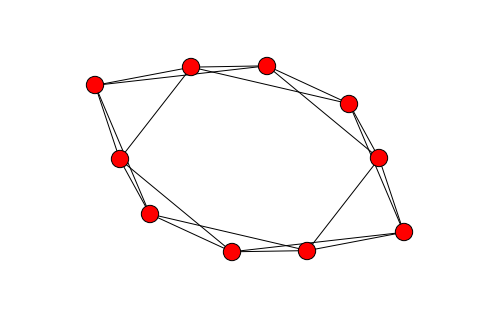

In [478]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline  

###Check Erdos-Renyi Graph
# G = create_erdos(8, 1.)
# TG = nx.Graph(G.matrix)
# nx.draw(TG, pos=nx.spring_layout(TG))

#G.find_path(0,4)
#G.find_all_paths(5,4)
#G.find_shortest_path(3,7)
#print G.diameter()


###Check Watts Graph
G = create_watts(n=10, k=5, p=0.0)
TG = nx.Graph(G.matrix)
nx.draw(TG, pos=nx.spring_layout(TG))

# G.find_path(0,9)
# G.find_all_paths(5,4)
# G.find_shortest_path(3,7)
# print G.diameter()

### Check Barabasi Graph
# G = create_barabasi(12, 2)
# TG = nx.Graph(G.matrix)
# nx.draw(TG, pos=nx.spring_layout(TG))

# G.matrix_to_nodedict()
# G.find_path(0,10)
# G.find_all_paths(5,4)
# G.find_shortest_path(3,7)
# print G.diameter()


###Test Graph functions



In [435]:
print G.local_clustering(0)
print G.average_clustering()

0
0.0


# Anaylitics

## Diameter

### Erdõs

[  1.   2.   2.   2.   2.   2.   5.  inf  inf  inf  inf]
Wall time: 246 ms


c:\users\abel_\anaconda\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: elementwise comparison failed; this will raise the error in the future.


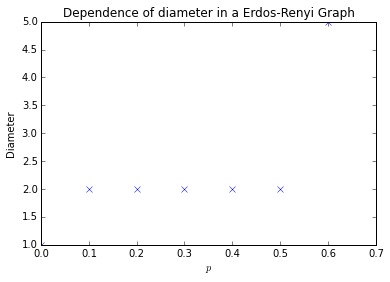

In [450]:
%%time
x = np.arange(0.0,1.1,0.1)
ytotal = np.zeros(11)
samnum = 1
for i in range(samnum):
    y = []
    for p in np.arange(0.0,1.1,0.1):
        G = create_erdos(n=7, p=p)
        y.append(G.diameter())
    ytotal += y
    
ymean = ytotal/float(samnum)
print ymean
    
fig = plt.plot(x, ymean, 'x')
plt.title("Dependence of diameter in a Erdos-Renyi Graph")
plt.xlabel(r"$p$")
plt.ylabel("Diameter")

### Watts

[ 3.   3.4  3.6  4.1  4.4  4.1  3.9  4.   3.7  3.7  3.8]
Wall time: 104 ms


c:\users\abel_\anaconda\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: elementwise comparison failed; this will raise the error in the future.


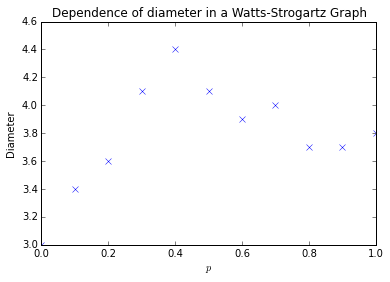

In [445]:
%%time
x = np.arange(0.0,1.1,0.1)
ytotal = np.zeros(11)
samnum = 10
for i in xrange(samnum):
    y = []
    for p in np.arange(0.0,1.1,0.1):
        G = create_watts(n=7, k=2, p=p)
        y.append(G.diameter())
    ytotal += y
    
ymean = ytotal/float(samnum)
print ymean
    
fig = plt.plot(x, ymean, 'x')
plt.title("Dependence of diameter in a Watts-Strogartz Graph")
plt.xlabel(r"$p$")
plt.ylabel("Diameter")

### Barabási

[ 3.6  2.5  2.   2. ]
Wall time: 115 ms


c:\users\abel_\anaconda\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: elementwise comparison failed; this will raise the error in the future.


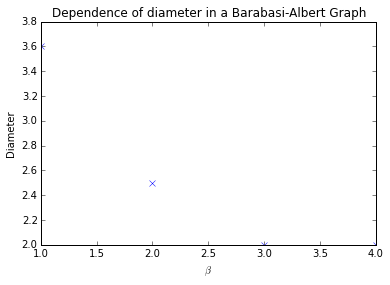

In [452]:
%%time
samnum = 10
nnodes = 5
x = range(1,nnodes)
ytotal = np.zeros(nnodes-1)
for exp in range(samnum):
    y = []
    for i in range(1,nnodes):
        G = create_barabasi(7, i)
        y.append(G.diameter())
    ytotal += y
    
ymean = ytotal/float(samnum)
print ymean
    
fig = plt.plot(x, ymean, 'x')
plt.title("Dependence of diameter in a Barabasi-Albert Graph")
plt.xlabel(r"$\beta$")
plt.ylabel("Diameter")

## Clustering

### Erdõs

c:\users\abel_\anaconda\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: elementwise comparison failed; this will raise the error in the future.


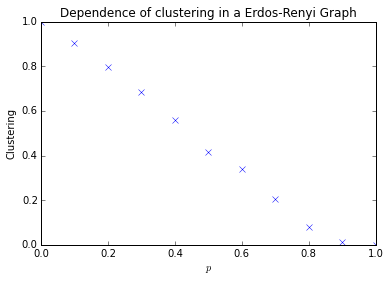

In [515]:
x = np.array(np.arange(0.0,1.1,0.1)) 
ytotal = np.zeros((1,11))
samnum = 100
for i in range(samnum):
    y = []
    for p in np.arange(0.0,1.1,0.1):
        G = create_erdos(n=7, p=p)
        y.append(G.average_clustering())
    ytotal += np.array(y)
ytotal = ytotal/float(samnum)
plt.plot(x,ytotal[0], 'x')
plt.title("Dependence of clustering in a Erdos-Renyi Graph")
plt.xlabel(r"$p$")
plt.ylabel("Clustering")

### Watts

c:\users\abel_\anaconda\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: elementwise comparison failed; this will raise the error in the future.


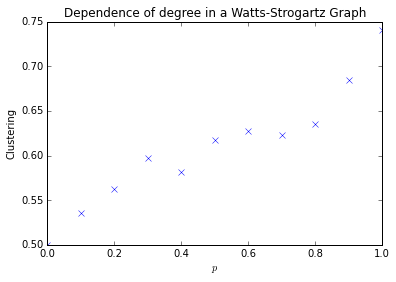

In [516]:
x = np.array(np.arange(0.0,1.1,0.1))
ytotal = np.zeros((1,11))
samnum = 100
for i in range(samnum):
    y = []
    for p in np.arange(0.0,1.1,0.1):
        G = create_watts(n=7, k=5, p=p)
        y.append(G.average_clustering())
    ytotal += np.array(y)
ytotal = ytotal/samnum
plt.plot(x,ytotal[0], 'x')

plt.title("Dependence of degree in a Watts-Strogartz Graph")
plt.xlabel(r"$p$")
plt.ylabel("Clustering")

### Barabasi

c:\users\abel_\anaconda\lib\site-packages\ipykernel\__main__.py:224: RuntimeWarning: invalid value encountered in divide
c:\users\abel_\anaconda\lib\site-packages\ipykernel\__main__.py:225: RuntimeWarning: invalid value encountered in less
c:\users\abel_\anaconda\lib\site-packages\ipykernel\__main__.py:225: RuntimeWarning: invalid value encountered in greater
c:\users\abel_\anaconda\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: elementwise comparison failed; this will raise the error in the future.


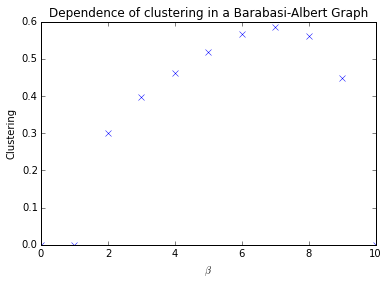

In [517]:
x = range(11)
ytotal = np.zeros((1,11))
samnum = 100
for i in range(samnum):
    y = []
    for n_0 in range(11):
        G = create_barabasi(n=12, n_0=n_0)
        y.append(G.average_clustering())
    ytotal += np.array(y)
ytotal = ytotal/samnum
plt.plot(x,ytotal[0], 'x')
plt.title("Dependence of clustering in a Barabasi-Albert Graph")
plt.xlabel(r"$\beta$")
plt.ylabel("Clustering")

## Degree Distribution

## Erdõs

In [ ]:
x = np.array(np.arange(0.0,1.1,0.1)) 
ytotal = np.zeros((1,11))
samnum = 100
for i in range(samnum):
    y = []
    for p in np.arange(0.0,1.1,0.1):
        G = create_erdos(n=7, p=p)
        y.append(G.average_degree())
    ytotal += np.array(y)
ytotal = ytotal/float(samnum)
plt.plot(x,ytotal[0], 'x')
plt.title("Dependence of average degree in a Erdos-Renyi Graph")
plt.xlabel(r"$p$")
plt.ylabel("Clustering")